In [1]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.7/776.7 kB 31.3 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully 

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

<ipython-input-2-b00b07bf67a6>:40: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  tpu_backend = xla_bridge.get_backend('tpu')
<ipython-input-2-b00b07bf67a6>:51: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  gpu_backend = xla_bridge.get_backend('gpu')


Set platform to GPU


# Prepare the Dataset

For the rescaled image matrix $M$, the "Hermitian version" of it can be calculated as:

$$
A = \frac{M+M^T}{2}
$$

In [3]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.squeeze(x)),
    #torchvision.transforms.Lambda(lambda x: x / torch.trace(x)),
    torchvision.transforms.Lambda(lambda x: (x+torch.transpose(x, 0, 1))/2)
])

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,16])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 532kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.09MB/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw

(64, 32, 32)
(64,)
[8 3 6 2 2 6 0 7 1 5 2 8 0 3 2 5 5 2 5 6 8 7 0 7 5 4 9 8 6 6 8 9 6 1 9 3 6
 6 3 5 6 5 0 9 5 3 8 4 7 5 3 6 1 3 4 4 1 8 0 0 0 6 7 6]
[0.         0.         0.         0.         0.         0.
 0.03529412 0.42352942 0.49411765 0.49411765 0.32156864 0.2882353
 0.37254903 0.8372549  0.9901961  0.9901961  0.99215686 0.74313724
 0.2784314  0.01764706 0.         0.         0.3392157  0.49411765
 0.49411765 0.2882353  0.         0.         0.         0.
 0.         0.        ]


# Time-Evolve the Image Hermitian

In [4]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==32 and img.shape[-2] == 32, f"The shape of the image must be 32 by 32, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        dummy_x[0],
        10
        )[16]
    )


print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        ))),
        img_hermitian_evolve(
        dummy_x[0],
        10
        )
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        img_hermitian_evolve(
        dummy_x[0],
        10
        ),
        jnp.transpose(jnp.conjugate(img_hermitian_evolve(
        dummy_x[0],
        10
        )))
    )
)

[ 0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.0133053 +0.32776695j -0.13960744-0.08826586j  0.09318478+0.11163554j
 -0.04531651+0.00614501j  0.01887171+0.02600457j -0.09153817+0.2006153j
  0.00585767+0.30063125j -0.23966607-0.11708803j  0.16342534+0.09855296j
 -0.47697222+0.13986035j -0.29202753+0.03685165j -0.0264953 +0.00152145j
  0.07925471+0.07090805j  0.05172904-0.2127653j  -0.09982113-0.1487077j
  0.14925534+0.02026174j -0.04262445-0.08797079j  0.04105659+0.0574732j
 -0.34935498+0.06881022j -0.05287408+0.04101484j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+

# Some Utilities

In [5]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])

pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )

pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            )

observables_10_cls_5q = [0]*10
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <10:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_10_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))

observables_8_cls_5q = [0]*8
for i in ['0', '1']:
  for j in ['0', '1']:
    for k in ['0', '1']:
      for l in ['0', '1']:
        idx = int(i+j+k+l, 2)
        if idx <8:
          basis_state = tensor_product(*[ket[i], ket[j], ket[k], ket[l]])
          four_qubit_obs = jnp.outer(basis_state, basis_state)
          observables_8_cls_5q[idx] = tensor_product(four_qubit_obs, multi_qubit_identity(1))


In [6]:
def su32_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk - >jk", params, jnp.asarray(list(pauli_words_su32.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[4**5-1], key=jrng_key)

print(
    jnp.einsum(
        "ij,jk->ik",
        jnp.transpose(jnp.conjugate(su32_op(test_params))),
        su32_op(test_params)
    )
)

print(
    jnp.einsum(
        "ij,jk->ik",
        su32_op(test_params),
        jnp.transpose(jnp.conjugate(su32_op(test_params)))
    )
)

[[ 1.00000000e+00-2.81802478e-18j -2.08166817e-17-6.93889390e-17j
   1.87350135e-16+4.02455846e-16j ...  6.78276879e-16-5.07189776e-16j
  -7.11236625e-16+6.24500451e-17j -2.53269627e-16-5.55111512e-16j]
 [-2.08166817e-17+4.85722573e-17j  1.00000000e+00+1.79597214e-18j
   3.78169718e-16-5.82867088e-16j ...  8.04911693e-16-1.17267307e-15j
   4.85722573e-17-4.51089090e-16j -2.35922393e-16-2.22044605e-16j]
 [ 1.87350135e-16-3.95516953e-16j  3.78169718e-16+5.55111512e-16j
   1.00000000e+00-1.01336686e-18j ...  6.38378239e-16+8.18789481e-16j
  -2.74086309e-16-5.20417043e-16j  4.85722573e-17-4.23272528e-16j]
 ...
 [ 6.81746326e-16+5.07189776e-16j  7.91033905e-16+1.17267307e-15j
   6.93889390e-16-8.18789481e-16j ...  1.00000000e+00-1.40196419e-18j
  -1.75207071e-16+8.53483950e-16j  3.46944695e-16-6.38378239e-16j]
 [-7.04297731e-16-6.24500451e-17j  4.16333634e-17+4.51089090e-16j
  -2.63677968e-16+5.20417043e-16j ... -1.75207071e-16-8.60422844e-16j
   1.00000000e+00+4.01611805e-18j -1.38777878e-

In [7]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)

# The QNN

With data re-uploading

$$
|{\varphi(\theta,t)}\rangle = \Pi_n (\mathrm{ParameterisedLayers}(\theta_n) e^{-\frac{it_n}{2}M} )|+\rangle^{\otimes 5}
$$

In [8]:
def qnn_hamevo(
    params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A QNN that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for trainable layers
  and output an array of 2 elements representing classification logits
  """
  single_op_params = 4**5-1

  n_outer_layers = len(t)
  n_inner_layers = (len(params)//single_op_params)//n_outer_layers
  state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])
  for i in range(n_outer_layers):
    state = jnp.dot(
      img_hermitian_evolve(img, t[i]),
      state
      )
    inner_layer_params = params[i*(single_op_params*n_inner_layers):(i+1)*(single_op_params*n_inner_layers)]
    for j in range(n_inner_layers):
      state = jnp.dot(
          #brickwall_su4_5q_single_layer(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          su32_op(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          state
      )
  return vmap_measure_sv(state, jnp.asarray(observables_8_cls_5q))



print(
    qnn_hamevo(
        jax.random.normal(shape=[( 4**5-1)*15], key=jrng_key),
        jax.random.normal(shape=[15], key=jrng_key),
        dummy_x[0]
    )
)

[0.14296242 0.04809052 0.01028421 0.04717641 0.07371877 0.04860805
 0.11448403 0.0305749 ]


# Training

In [9]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    out = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(out, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [10]:
N_OUTER_LAYERS = 10
N_INNER_LAYERS = 1
N_LAYERS = N_OUTER_LAYERS*N_INNER_LAYERS
SINGLE_OP_PARAMS  = 4**5-1

def init_weights():
    return jax.random.normal(shape=[SINGLE_OP_PARAMS*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_OUTER_LAYERS], key=jrng_key)

In [12]:
import pandas as pd
import os

def save_weights_to_csv(weights, biases, epoch, file_name='weights_beta.csv'):
    """Saves the weights and biases to a CSV file."""
    # Convert weights and biases to a flat list
    weight_list = weights.flatten().tolist()
    bias_list = biases.flatten().tolist()

    # Create a dictionary to store the weights and biases with epoch
    data = {'epoch': [epoch], 'weights': [weight_list], 'biases': [bias_list]}

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Check if the file exists before appending
    if not os.path.isfile(file_name):
        # If the file does not exist, create it with a header
        df.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # If the file exists, append the new data without a header
        df.to_csv(file_name, mode='a', header=False, index=False)

In [13]:
# Select data
labels = [0, 1, 2, 3, 4, 5, 6, 7]
indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]

# Separate 5% of the training data for validation
val_size = int(0.05 * len(indices_train))
indices_val = indices_train[:val_size]  # First 5% for validation
indices_train = indices_train[val_size:]  # Remaining 95% for training

indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

N_TRAIN = len(indices_train)
N_VAL = len(indices_val)
N_TEST = len(indices_test)

print(
    f"Training with: {N_TRAIN}; Validation test: {N_VAL}; Testing with: {N_TEST}"
)

Training with: 45790; Validation test: 2410; Testing with: 8017


In [14]:
def train_vqc(batchsize: int, n_epochs: int, seed: int = 1701):
    start = time.time()
    np.random.seed(seed)

    # Load data
    labels = [0, 1, 2, 3, 4, 5, 6, 7]
    indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
    indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

    N_TRAIN = len(indices_train)

    # Calculate the number of validation samples (5%)
    n_val = int(0.05 * N_TRAIN)  # 5% for validation
    n_train = N_TRAIN - n_val  # Remaining for training

    # Shuffle the training indices
    np.random.shuffle(indices_train)

    # Split the indices into training and validation
    indices_val = indices_train[:n_val]  # First 5% for validation
    indices_train_final = indices_train[n_val:]  # Remaining for training

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(train_dataset, indices_train_final), batch_size=batchsize, shuffle=True
    )
    valloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(train_dataset, indices_val), batch_size=batchsize, shuffle=False
    )

    # Exponential decay of the learning rate.
    scheduler = optax.exponential_decay(
        init_value=0.01,
        transition_steps=n_epochs,
        decay_rate=0.99
    )

    # Combining gradient transforms using `optax.chain`.
    gradient_transform = optax.chain(
        optax.clip(1.0),
        optax.scale_by_adam(),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0)
    )

    # Init weights and optimizer
    weights, weights_last = init_weights()
    opt_state = gradient_transform.init((weights, weights_last))

    # Data containers
    train_cost_epochs, val_cost_epochs, train_acc_epochs, val_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        val_cost_batches = []
        val_acc_batches = []

        epoch_start = time.time()
        print(f"Training at Epoch {step + 1}/{n_epochs}, Train batches {len(trainloader)}, Val batches {len(valloader)}......")

        # Training loop
        for batch, (x_train, y_train) in enumerate(trainloader):
            batch_start = time.time()
            x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
            train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
            updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
            weights, weights_last = optax.apply_updates((weights, weights_last), updates)
            train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
            train_cost_batches.append(train_cost)
            train_acc_batches.append(train_acc)

            if len(trainloader) <= 5 or (batch + 1) % 5 == 0:
                print(f"Training at Epoch {step + 1}/{n_epochs}, Batch {batch + 1}, Cost {train_cost}, Acc {train_acc}. Time {time.time() - batch_start}")

        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))

        # Validation loop
        for batch, (x_val, y_val) in enumerate(valloader):
            x_val, y_val = jnp.asarray(x_val.numpy()), jnp.asarray(y_val.numpy())
            val_out = compute_out(weights, weights_last, x_val, y_val)
            val_pred = jnp.argmax(val_out, axis=1)
            val_acc = jnp.sum(jnp.array(val_pred == y_val).astype(int)) / len(val_out)
            val_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(val_out, y_val))
            val_cost_batches.append(val_cost)
            val_acc_batches.append(val_acc)

        val_acc_epochs.append(np.mean(val_acc_batches))
        val_cost_epochs.append(np.mean(val_cost_batches))

        print("......")
        print(f"Epoch {step + 1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step + 1}/{n_epochs}, Validation: Cost {np.mean(val_cost_batches)}, Acc {np.mean(val_acc_batches)}")
        print("=-=" * 10)
        save_weights_to_csv(weights, weights_last, step+1, file_name="weights.csv")
    return dict(
        n_train=[N_TRAIN] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        val_cost=[c.astype(float) for c in val_cost_epochs],
        val_acc=[c.astype(float) for c in val_acc_epochs],
    )




In [15]:
n_epochs = 50
n_reps = 1
batch_size = 1000

train_sizes = [N_TRAIN]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "val_acc", "val_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_vqc(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Training at Epoch 1/50, Train batches 46, Val batches 3......


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Training at Epoch 1/50, Batch 5, Cost 1.9930321230243238, Acc 0.481. Time 2.5076889991760254
Training at Epoch 1/50, Batch 10, Cost 1.9274959221357983, Acc 0.617. Time 2.7528274059295654
Training at Epoch 1/50, Batch 15, Cost 1.8870331588831957, Acc 0.66. Time 2.552356481552124
Training at Epoch 1/50, Batch 20, Cost 1.8609074613407615, Acc 0.726. Time 2.527357339859009
Training at Epoch 1/50, Batch 25, Cost 1.830428857786048, Acc 0.733. Time 2.5223872661590576
Training at Epoch 1/50, Batch 30, Cost 1.8116220578727673, Acc 0.742. Time 2.500474691390991
Training at Epoch 1/50, Batch 35, Cost 1.7881241197433682, Acc 0.784. Time 2.5011749267578125
Training at Epoch 1/50, Batch 40, Cost 1.7813128206267144, Acc 0.786. Time 2.493590831756592
Training at Epoch 1/50, Batch 45, Cost 1.7721840176286237, Acc 0.781. Time 2.5075440406799316


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


......
Epoch 1/50, Train: Cost 1.8637521151472856, Acc 0.675382773802972
Epoch 1/50, Validation: Cost 1.7685672391979521, Acc 0.765991869918699
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 2/50, Train batches 46, Val batches 3......
Training at Epoch 2/50, Batch 5, Cost 1.757964698318531, Acc 0.797. Time 2.531416893005371
Training at Epoch 2/50, Batch 10, Cost 1.7634649970423566, Acc 0.774. Time 2.5607047080993652
Training at Epoch 2/50, Batch 15, Cost 1.74421913989596, Acc 0.789. Time 2.5425233840942383
Training at Epoch 2/50, Batch 20, Cost 1.7445804451642166, Acc 0.805. Time 2.5260918140411377
Training at Epoch 2/50, Batch 25, Cost 1.7184218198742747, Acc 0.817. Time 2.503967761993408
Training at Epoch 2/50, Batch 30, Cost 1.7274615376009075, Acc 0.793. Time 2.499241828918457
Training at Epoch 2/50, Batch 35, Cost 1.7175424919149613, Acc 0.818. Time 2.4835875034332275
Training at Epoch 2/50, Batch 40, Cost 1.7294099250947437, Acc 0.798. Time 2.3817429542541504
Training at Epoch 

<ipython-input-15-27e2789f097d>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(


In [16]:
testloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(test_dataset, indices_test), batch_size=1000, shuffle=False
    )
def test_model(testloader, weights, weights_last):
    test_cost_batches = []
    test_acc_batches = []

    # Initialize accumulators for total cost and correct predictions
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    print("Testing the model...")

    # Iterate through the entire test dataset
    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        # Get model predictions
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_pred = jnp.argmax(test_out, axis=1)

        # Compute accuracy
        correct_predictions += jnp.sum(jnp.array(test_pred == y_test).astype(int))
        total_samples += len(y_test)

        # Compute cost
        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
        total_cost += test_cost * len(y_test)  # Accumulate total cost

    # Compute overall test results
    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples

    print(f"Final Test: Cost {avg_test_cost}, Acc {avg_test_acc}")

# Example usage:
# test_model(testloader, results['weights'], results['weights_last'])


In [18]:
import pandas as pd
import ast
import jax.numpy as jnp  # Import JAX's NumPy

# Read the CSV file
df = pd.read_csv('weights.csv')

# Check if the DataFrame is not empty
if not df.empty:
    # Access the last row directly
    row = df.iloc[-1]  # Access the last row

    # Extract the epoch, weights, and biases
    epoch = row['epoch']
    weights = jnp.array(ast.literal_eval(row['weights']))  # Convert to JAX array
    biases = jnp.array(ast.literal_eval(row['biases']))    # Convert to JAX array

    # Call your test model function with the extracted weights and biases
    test_model(testloader, weights, biases)

    # Print the epoch and first few weights and biases
    print(f"Epoch: {epoch}, Weights: {weights[:5]}, Biases: {biases}")

else:
    print("The DataFrame is empty.")


Testing the model...
Final Test: Cost 1.5893307450346774, Acc 0.8904827242110516
Epoch: 50, Weights: [-0.70008666  0.25437779  1.57274372  1.51067396  0.11391951], Biases: [ 0.51087077  0.54826193  0.80972323 -0.72963426  0.63962985 -0.0446401
  0.49959526  0.39508748 -0.45102223  0.39048551]


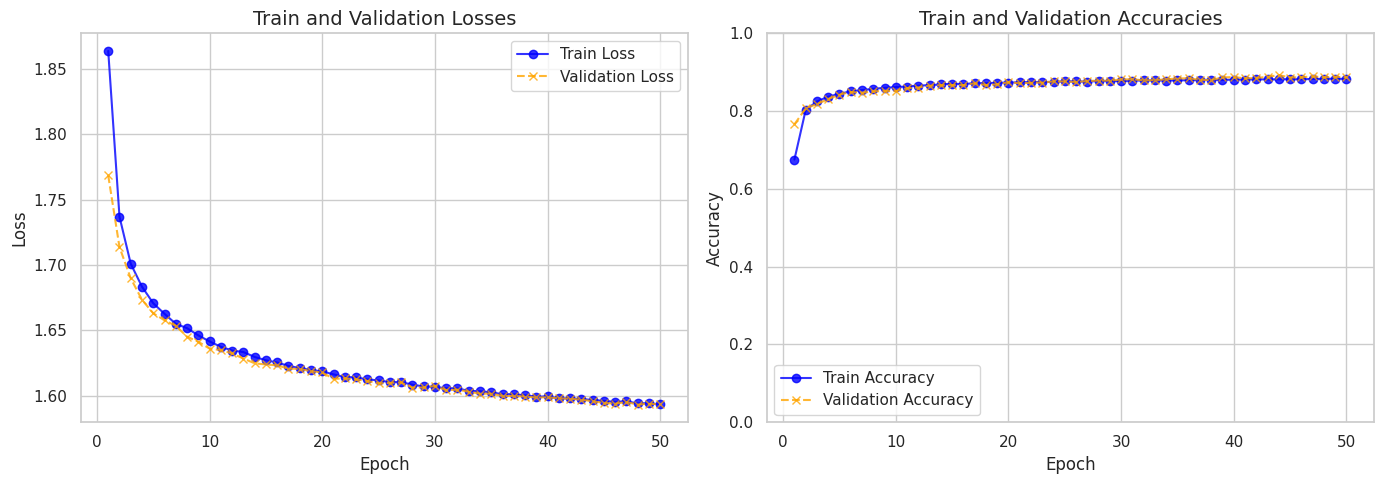

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `results_df` is already loaded and contains columns:
# 'train_acc', 'train_cost', 'val_acc', 'val_cost', 'step', 'n_train'
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()
# Plotting settings
sns.set_style('whitegrid')
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

# Plot losses (train_cost and val_cost)
axes[0].plot(results_df['step'], results_df['train_cost'], 'o-', label='Train Loss', color='blue', alpha=0.8)
axes[0].plot(results_df['step'], results_df['val_cost'], 'x--', label='Validation Loss', color='orange', alpha=0.8)
axes[0].set_title('Train and Validation Losses', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracies (train_acc and val_acc)
axes[1].plot(results_df['step'], results_df['train_acc'], 'o-', label='Train Accuracy', color='blue', alpha=0.8)
axes[1].plot(results_df['step'], results_df['val_acc'], 'x--', label='Validation Accuracy', color='orange', alpha=0.8)
axes[1].set_title('Train and Validation Accuracies', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [22]:
save_folder = "/content/result_Mnist_Random"
results_df.to_csv(os.path.join(save_folder, "mnist_HermImgReUpload_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "mnist_HermImgReUpload_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "mnist_HermImgReUpload_results.png"))